In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
#!cd /content/gdrive/My\ Drive/BioImage/Project
!pip install --upgrade --force-reinstall --no-deps kaggle
import os
os.environ['KAGGLE_USERNAME'] = "serenaabraham" 
os.environ['KAGGLE_KEY'] = "0aa4e1881376dfb2149dcfb30ffe7975"

Mounted at /content/gdrive
     |████████████████████████████████| 61kB 3.1MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=f77503b3d28a67aa5b7c07e4e5d940ae9d485b50d09087cea14b460ebdf7d517
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [2]:
!kaggle datasets download -d andrewmvd/malignant-lymphoma-classification
!unzip -q /content/malignant-lymphoma-classification.zip

 99% 1.33G/1.34G [01:27<00:01, 9.67MB/s]
100% 1.34G/1.34G [01:27<00:00, 16.6MB/s]


In [5]:
from skimage import io
import matplotlib.pyplot as plt

for fn in os.listdir('inputs/MCL'):
  if(fn.endswith('.tif')):
    original = io.imread('inputs/MCL/' + fn, plugin='tifffile')
    height, width, length = original.shape
    width_cutoff=width//2
    img1=original[:,:width_cutoff,:]
    img2=original[:,width_cutoff:,:]
    plt.imsave('inputs/MCL/' + fn[:-4] + '1.png', img1)
    plt.imsave('inputs/MCL/' + fn[:-4] + '2.png', img2)
    os.remove('inputs/MCL/'+fn)

In [6]:
!pip install split_folders
import splitfolders
splitfolders.ratio('inputs', output='output', seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 748 files [00:03, 211.54 files/s]


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.optim.lr_scheduler import StepLR
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
from torchvision import datasets, models, transforms



import os
import random
import numpy as np
import time

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

def load_dataset():
    train_data_path = './output/train'
    test_data_path = './output/test'
    valid_data_path = './output/val'

    train_dataset = torchvision.datasets.ImageFolder(root=train_data_path,transform=torchvision.transforms.ToTensor())
    test_dataset = torchvision.datasets.ImageFolder(root=test_data_path,transform=torchvision.transforms.ToTensor())
    valid_dataset = torchvision.datasets.ImageFolder(root=valid_data_path,transform=torchvision.transforms.ToTensor())

    train_iterator = torch.utils.data.DataLoader(train_dataset,batch_size=32,num_workers=0,shuffle=True)
    test_iterator = torch.utils.data.DataLoader(test_dataset,batch_size=32,num_workers=0,shuffle=False)
    valid_iterator = torch.utils.data.DataLoader(valid_dataset,batch_size=32,num_workers=0,shuffle=True)

    return train_iterator, test_iterator, valid_iterator



def calculate_accuracy(fx, y):
    preds = fx.max(1, keepdim=True)[1]
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc



def train(model, device, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in iterator:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        fx = model(x)

        loss = criterion(fx, y)

        acc = calculate_accuracy(fx, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    #scheduler.step()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)




def evaluate(model, device, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            fx = model(x)

            loss = criterion(fx, y)

            acc = calculate_accuracy(fx, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [8]:
from torchvision import datasets, models, transforms
model=models.resnet18(pretrained=True)
#set_parameter_requires_grad(model, True)
num_ftrs = 512
num_classes = 3
model.fc = nn.Linear(num_ftrs, num_classes)
import time
params_to_update = []
for name,param in model.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print("\t",name)
learningRate = 1e-2
weightDecay = 5e-5
numEpochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params_to_update, lr=learningRate, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight
	 laye

|Epoch: 1 | Train loss: 0.929 | Train Acc: 61.32% | Val Loss : 1.992 | Val Acc: 43.40% | Time used: 50s |
|Epoch: 2 | Train loss: 0.627 | Train Acc: 73.59% | Val Loss : 4.177 | Val Acc: 34.03% | Time used: 50s |
|Epoch: 3 | Train loss: 0.435 | Train Acc: 84.69% | Val Loss : 1.377 | Val Acc: 74.31% | Time used: 50s |
|Epoch: 4 | Train loss: 0.482 | Train Acc: 81.97% | Val Loss : 1.485 | Val Acc: 67.59% | Time used: 50s |
|Epoch: 5 | Train loss: 0.331 | Train Acc: 88.23% | Val Loss : 0.723 | Val Acc: 74.42% | Time used: 50s |
|Epoch: 6 | Train loss: 0.237 | Train Acc: 90.95% | Val Loss : 1.726 | Val Acc: 64.35% | Time used: 50s |
|Epoch: 7 | Train loss: 0.317 | Train Acc: 88.31% | Val Loss : 1.031 | Val Acc: 74.42% | Time used: 50s |
|Epoch: 8 | Train loss: 0.293 | Train Acc: 88.23% | Val Loss : 1.078 | Val Acc: 63.89% | Time used: 50s |
|Epoch: 9 | Train loss: 0.308 | Train Acc: 90.21% | Val Loss : 0.421 | Val Acc: 83.80% | Time used: 50s |
|Epoch: 10 | Train loss: 0.220 | Train Acc: 91

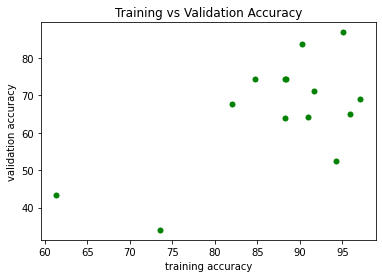

| Test Loss: 0.652 | Test Acc: 76.04% |


In [9]:
import matplotlib.pyplot as plt

if __name__ == "__main__":

    train_iterator, test_iterator, valid_iterator = load_dataset()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #model=Net()
    #model=MobileNet()
    model.to(device)

    optimizer = optim.Adam(model.parameters())
    scheduler = StepLR(optimizer, step_size=5, gamma=0.2)

    criterion = nn.CrossEntropyLoss()

    trainSet=[]
    validSet=[]


    ### Training ###
    EPOCHS = 14
    SAVE_DIR = 'models'
    MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'mlp-mnist.pt')

    best_valid_loss = float('inf')
    time_curr = time.time()

    if not os.path.isdir(f'{SAVE_DIR}'):
        os.makedirs(f'{SAVE_DIR}')

    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model, device, train_iterator, optimizer, criterion)
        valid_loss, valid_acc = evaluate(model, device, valid_iterator, criterion)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), MODEL_SAVE_PATH)

        print("|Epoch: {0:d} | Train loss: {1:.3f} | Train Acc: {2:.2f}% | Val Loss : {3:.3f} | Val Acc: {4:.2f}% | Time used: {5:d}s |".format(epoch+1,
            train_loss, train_acc*100, valid_loss, valid_acc*100, int(time.time()-time_curr)))
        
        trainSet.append(train_acc*100)
        validSet.append(valid_acc*100) 

        time_curr = time.time()
    plt.plot(trainSet, validSet, 'go', markersize=5.0)
    plt.xlabel("training accuracy")
    plt.ylabel("validation accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.show()


    ### Testing ###
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))

    test_loss, test_acc = evaluate(model, device, test_iterator, criterion)

    print('| Test Loss: {0:.3f} | Test Acc: {1:.2f}% |'.format(test_loss,test_acc*100))


In [ ]:
trainSet

[71.10745624492043,
 75.56390981925162,
 84.8527569519846,
 87.99342105263158,
 90.44486221514249,
 91.93295742336073,
 92.26190479178177,
 92.09743110757125,
 94.56453637072914,
 92.67700502746983,
 95.88815789473685,
 95.55921052631578,
 95.39473684210526,
 96.05263157894737]

[61.31735600923237, 73.5902256087253, 84.68828326777408, 81.97055145313865, 88.22838350346214, 90.95394736842105, 88.31453637072914, 88.22838350346214, 90.20989976431194, 91.69016292220668, 97.11779450115404, 94.23558900230809, 95.88032584441336, 95.05795742336073]


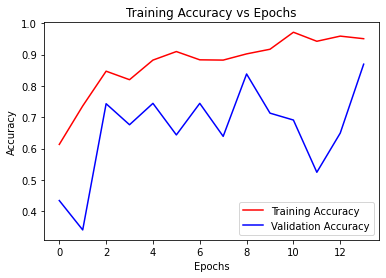

In [10]:
#print(trainSet)
print(trainSet)
trainSetnew=[i/100 for i in trainSet]
validSetnew=[i/100 for i in validSet]
plt.plot(trainSetnew,'r')
plt.plot(validSetnew, 'b')
plt.legend(["Training Accuracy","Validation Accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Epochs")
plt.show()
#print(trainSet)



In [11]:
def evaluate2(model, device, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0
    expected=[]
    calculated=[]

    model.eval()

    with torch.no_grad():
        for (x, y) in iterator:



            x = x.to(device)
            y = y.to(device)
            
            

            fx = model(x)
            preds = fx.max(1, keepdim=True)[1]
            correct = preds.eq(y.view_as(preds)).sum()
            
            expected.append(y)
            calculated.append(fx)

            loss = criterion(fx, y)

            

            acc = calculate_accuracy(fx, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), expected, calculated

In [12]:
test_loss, test_acc, expected, calculated = evaluate2(model, device, test_iterator, criterion)